# 03 - Interactive Viz

## Deadline
Friday October 28, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework we will practice with interactive visualization, which is the key ingredient of many successful viz (especially when it comes to infographics).
You will be working with the P3 database of the [SNSF](http://www.snf.ch/en/Pages/default.aspx) (Swiss National Science Foundation).
As you can see from their [entry page](http://p3.snf.ch/), P3 already offers some ready-made viz, but we want to build a more advanced one for the sake
of quick data exploration. Therefore, start by [downloading the raw data](http://p3.snf.ch/Pages/DataAndDocumentation.aspx) (just for the Grant Export), and read carefully
the documentation to understand the schema. Install then [Folium](https://github.com/python-visualization/folium) to deal with geographical data (*HINT*: it is not
available in your standard Anaconda environment, therefore search on the Web how to install it easily!) The README file of Folium comes with very clear examples, and links 
to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find a TopoJSON file with the 
geo-coordinates of each Swiss canton (which can be used as an overlay on the Folium maps).


## Assignment
1. Build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows intuitively (i.e., use colors wisely) how much grant money goes to each Swiss canton.
To do so, you will need to use the provided TopoJSON file, combined with the Choropleth map example you can find in the Folium README file.

*HINT*: the P3 database is formed by entries which assign a grant (and its approved amount) to a University name. Therefore you will need a smart strategy to go from University
to Canton name. The [Geonames Full Text Search API in JSON](http://www.geonames.org/export/web-services.html) can help you with this -- try to use it as much as possible
to build the canton mappings that you need. For those universities for which you cannot find a mapping via the API, you are then allowed to build it manually -- feel free to stop 
by the time you mapped the top-95% of the universities. I also recommend you to use an intermediate viz step for debugging purposes, showing all the universties as markers in your map (e.g., if you don't select the right results from the Geonames API, some of your markers might be placed on nearby countries...)

2. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in research funding
between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

*HINT*: for those cantons cut through by the Röstigraben, [this viz](http://p3.snf.ch/Default.aspx?id=allcharts) can be helpful!


In [41]:
from bs4 import BeautifulSoup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
sns.set_context('notebook')
import re
import requests as rq
import json
import google_helper as ggl_h
from scipy import stats

# Pre-Processing the datas

In [4]:
cantons_json_path = "data/ch-cantons.topojson.json"
cantons_csv_path = "data/P3_GrantExport.csv"

data = pd.read_csv(cantons_csv_path, sep=';')

We first read the datas from the CSV file and we drop the columns we don't need in the dataframe.

In [5]:
data = data.drop([ "Project Title", "Project Title English", "Responsible Applicant", "Funding Instrument", "Funding Instrument Hierarchy", "Discipline Number", "Discipline Name", "Discipline Name Hierarchy", "Start Date", "End Date", "Keywords"], axis=1)
data.head()

,"﻿""Project Number""",Institution,University,Approved Amount
0,1,NaN,Nicht zuteilbar - NA,11619.00
1,4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.00
2,5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.00
3,6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.00
4,7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.00


We are interested in the approved amount, so let's see if we have any non-numeric value first.

In [6]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
 
notNumbers = set([n for n in data['Approved Amount'] if not is_number(n)])
notNumbers

{'data not included in P3'}

As we see, there is a non-numerical value which is 'data not included in P3'. Now let's check what kind of values we have in the universities

In [7]:
universityValues = set(data['University'])

If look at the set, there are 2 values that won't be useful (NaN and 'Nicht zuteilbar - NA'). The NaN value is indicated in the description of the data ('Ce champ n’est rempli que dans le cas où la recherche est conduite dans une institution suisse, sinon ce champ est **vide**').

Hence we drop the rows where the value in the approved amount column is not a number (here "data not included in P3") since we can't get a numeric value from this.

Then we drop the lines where the university column equals "Nicht zuteilbar - NA" and "NaN" as we cannot find the cantons where they are located.

In [8]:
count_amount = data[data["Approved Amount"].isin(notNumbers)].shape[0]
count_uni = data[data["University"] == "Nicht zuteilbar - NA"].shape[0] + data[pd.isnull(data["University"])].shape[0]

print("Percentage of amount data not in P3 : ", (count_amount / data.shape[0]) * 100,"%")
print("Percentage of University not defined : ", (count_uni / data.shape[0]) * 100,"%")

before_deletion_size = data.shape[0]

print("Number of rows in the data before deletion : ", before_deletion_size)

data = data[~data["Approved Amount"].isin(notNumbers)]
data = data[data["University"] != "Nicht zuteilbar - NA"]
data = data.dropna(subset=['University'])

print("Number of rows in the data after deletion : ", data.shape[0])
print("Percentage of row deleted : ", ((before_deletion_size - data.shape[0]) / before_deletion_size) * 100, "%")

data = data.reset_index(drop=True)
data.head()

Percentage of amount data not in P3 :  17.055136081539494 %
Percentage of University not defined :  24.349294189372976 %
Number of rows in the data before deletion :  63969
Number of rows in the data after deletion :  48283
Percentage of row deleted :  24.52125248167081 %


,"﻿""Project Number""",Institution,University,Approved Amount
0,4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.00
1,5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.00
2,6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.00
3,7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.00
4,8,"Séminaire de politique économique, d'économie ...",Université de Fribourg - FR,53009.00


To the end we filtered 24% of the data (which is non-negligeable but necessary).

# Find each university's canton

Now that the data is pre-processed, we need to map each university to the right canton. We first fetch the set of universities' name from the dataframe.

In [9]:
universities = data.University.unique()
' | '.join(universities[:5])

'Université de Genève - GE | NPO (Biblioth., Museen, Verwalt.) - NPO | Universität Basel - BS | Université de Fribourg - FR | Universität Zürich - ZH'

Once we have these names, we try to get the appropriate canton using the following steps (with our helper file google_helper):
- get the name of the university (splitting by dash and taking the first part)
- use the Google Maps Geocoding API to fetch the corresponding canton (in 'administrative_area_level_1')
- it's possible that some names does not return any results, in this case we switch to another API, which is Google Places, that fetches the longitude and latitute coordinates for a place
- once we have these coordinates, we use reverse geocoding to get the canton name

Doing it in two steps decreased the number of locations not found from 48 to 18.

In [10]:
cantons_ids_google = ggl_h.canton_ids(universities)
' | '.join(map(str, cantons_ids_google[:5]))

"('Université de Genève', 'GE') | ('NPO (Biblioth., Museen, Verwalt.)', None) | ('Universität Basel', 'BS') | ('Université de Fribourg', 'FR') | ('Universität Zürich', 'ZH')"

So we have now each university mapped to a canton, but we may miss some (i.e mapped with None), or some that are mapped to a place not in Switzerland (for instance there was an institution based in Rome).

Using the JSON topo for the map, we can get all the correct cantons ids, and build two list (one for correct mapped cantons and one for not found or not correctly mapped cantons).

In [11]:
input_file = open(cantons_json_path, 'r', encoding='utf-8')
canton_ids = [elem['id'] for elem in json.load(input_file)['objects']['cantons']['geometries']]

correct     = [t for t in cantons_ids_google if t[1] in canton_ids]
not_correct = [t for t in cantons_ids_google if t[1] not in canton_ids]

Now we build manually a lookup for the university names that were incorrectly or not mapped.

In [12]:
#Build lookup manually
lookup = {
 'AO Research Institute': 'GR',
 'Allergie': 'BE',
 'Eidg. Forschungsanstalt für Wald,Schnee,Land': 'ZH',
 'Eidg. Material und Prüfungsanstalt': 'ZH',
 'Fachhochschule Nordwestschweiz (ohne PH)': 'SO',
 'Firmen/Privatwirtschaft': None, #private society/sector so no location available
 'Forschungsanstalten Agroscope': None, #organism split into multiple cantons., can't assume equal distribution
 'Forschungsinstitut für Opthalmologie': 'VS',
 'Forschungsinstitut für biologischen Landbau': 'AG',
 'Forschungskommission SAGW': 'BE',
 'Haute école pédagogique BE, JU, NE': 'JU',
 'Inst. de Hautes Etudes Internat. et du Dév': 'GE',
 'Istituto Svizzero di Roma': None, #private fondation, in Rome
 'NPO (Biblioth., Museen, Verwalt.)': None, #non-profit organizations, can't assume equal distribution
 'Physikal.': None, #swiss physical society, can't assume equal distribution
 'Schweiz. Hochschule für Logopädie Rorschach': 'SG',
 'Schweizer Kompetenzzentrum Sozialwissensch.': 'VD',
 'Swiss Center for Electronics and Microtech.': 'NE',
 'Swiss Institute of Bioinformatics': 'VD',
 'Weitere Institute': None, #other institutes, can't assume equals distribution
 'Weitere Spitäler': None #other hospitals, can't assume equal distribution
}

In [17]:
map_ids = {**dict(correct), **lookup}

# Build the DataFrame 

We have know the mapping from university name to canton, so build the dataframe we proceed with the following steps:
+ add a new column 'Canton' in it, where the map is used to find the right canton according to the university name
+ keep only the 'Canton' and 'Approved Amount' columns
+ change the datatype of the values in the 'Approved Amount' column to be of type float
+ group by the cantons and sum the values aggregated

In [18]:
data_bis = data.copy()
data_bis['Canton'] = data_bis['University'].apply(lambda name: map_ids[name.split('-')[0].strip()])
data_bis = data_bis[['Canton', 'Approved Amount']]
data_bis['Approved Amount'] = data_bis['Approved Amount'].apply(lambda val : float(val))
data_grouped = data_bis.groupby('Canton').sum().reset_index()

In order to build the map, it's required to have every canton id present. So for each canton that is not already in the data frame, we add a new row (cantonId, 0).

In [19]:
cantons_missing = [[id_, 0] for id_ in canton_ids if id_ not in data_grouped.Canton.values]
df_missing = pd.DataFrame(cantons_missing, columns=['Canton', 'Approved Amount'])
data_grouped = data_grouped.append(df_missing, ignore_index=True)

Finally, we create a map of the coordinates values for each canton (we could have build it dynamically using BeautifulSoup and Selenium, but for 26 values, it was faster to do it manually). It will be used to draw markers on the map.

In [20]:
cantons_coordinates = {
    'ZH' : [47.377895, 8.541183],
    'BE' : [46.94909, 7.447357], 
    'LU' : [47.05, 8.3], 
    'UR' : [46.880826, 8.639446], 
    'SZ' : [47.020546, 8.658332], 
    'OW' : [46.897214, 8.24722], 
    'NW' : [46.95972, 8.366674], 
    'GL' : [47.033329, 9.066666], 
    'ZG' : [47.169441, 8.516663], 
    'FR' : [46.806103, 7.162775], 
    'SO' : [47.208331, 7.537513], 
    'BS' : [47.567, 7.583], 
    'BL' : [47.466667, 7.733333], 
    'SH' : [47.700001, 8.633333], 
    'AR' : [47.383329, 9.266671], 
    'AI' : [47.330828, 9.408615], 
    'SG' : [47.416667, 9.366667], 
    'GR' : [46.85, 9.533333],
    'AG' : [47.4, 8.05], 
    'TG' : [47.556, 8.8965], 
    'TI' : [46.2, 9.016667], 
    'VD' : [46.521, 6.631], 
    'VS' : [46.227778, 7.358611], 
    'NE' : [46.990281, 6.930567], 
    'GE' : [46.200013, 6.149985], 
    'JU' : [47.366667, 7.35]
}

We can now create the map, but before hand we want to have a nice treshold scale that is readable.

In [21]:
def get_exponent(x):
    if(x == 0):
        return 0
    else:
        return np.floor(np.log10(np.abs(x))).astype(int)

data_grouped['Approved Amount Magnitude'] = data_grouped['Approved Amount'].apply(get_exponent)
thresh_scale = np.unique(data_grouped['Approved Amount Magnitude'].values)
thresh_scale = list(np.delete(thresh_scale, 0))

In [22]:
import locale 
locale.setlocale(locale.LC_ALL, '')

swiss_map = folium.Map(location=[47, 8], zoom_start=8)
swiss_map.choropleth(geo_path=cantons_json_path, 
                     data=data_grouped,
                     columns=['Canton', 'Approved Amount Magnitude'],
                     threshold_scale=thresh_scale,
                     key_on='feature.id',
                     fill_opacity = 0.8,
                     line_opacity=0.4,
                     topojson='objects.cantons',
                     fill_color='BuPu',
                     legend_name = 'Grant money for each Swiss canton'
                    )

for key, value in cantons_coordinates.items():
    if(value != None):
        amount = locale.currency(data_grouped[data_grouped['Canton'] == key]['Approved Amount'].values[0], grouping=True)
        folium.Marker(value, popup=key + ' - ' + amount).add_to(swiss_map)
        
swiss_map.save('swiss_map.html')

In [23]:
#Display the map
swiss_map

# Run some statistical tests

In [24]:
project_amounts = data_bis.copy()
projects_amount_description = project_amounts.describe()
population_mean = project_amounts.mean() 
projects_amount_description

,Approved Amount
count,4.828300e+04
mean,2.658377e+05
std,3.257335e+05
min,0.000000e+00
25%,8.960600e+04
50%,1.885930e+05
75%,3.324195e+05
max,1.548775e+07


We plot the data in order to have a better comprehension of it. We thus obtain the number of projects in between amount values.

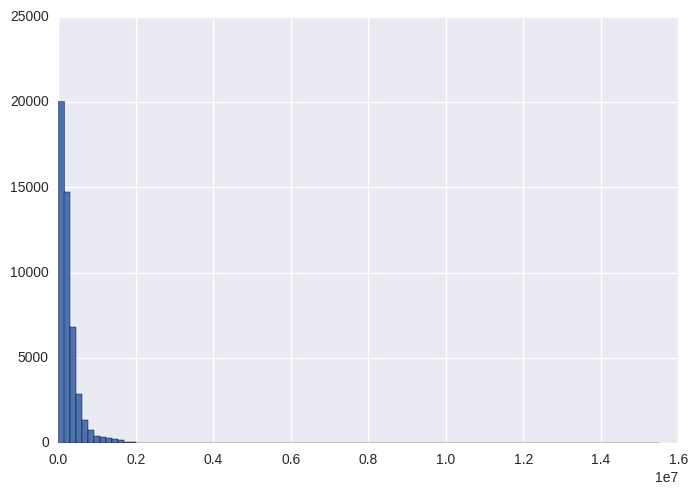

In [25]:
project_amounts['Approved Amount'].hist(bins = 100)         

We remove outliers to have a better visualization. We know that some projects have unusual high approved amounts. We thus remove the 5% top amounts.

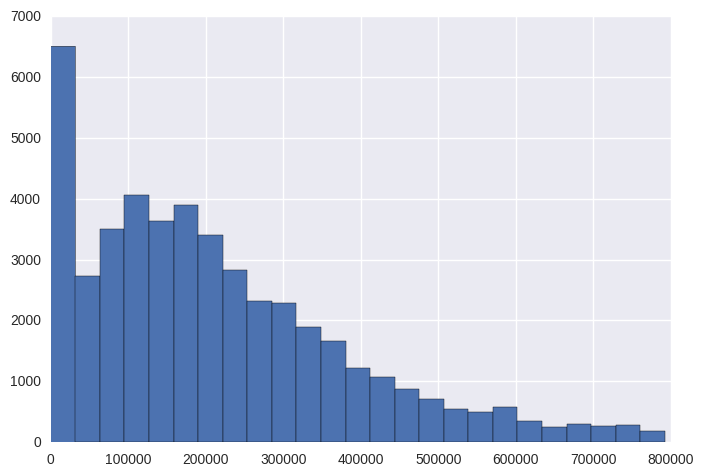

In [29]:
high_percentile = np.percentile(project_amounts['Approved Amount'], 95)
project_amounts_without_outliers = project_amounts[project_amounts['Approved Amount'] <= high_percentile]
project_amounts_without_outliers['Approved Amount'].hist(bins = 25)

We now want to know if there is a  statistically significant difference between each Cantons in terms of amounts injected. We thus will apply a hypothesis testing on each sub-sample (Canton distribution) with our null hypothesis being: 

     H0 := "Canton X has no significant difference in mean with the total population of approved amounts"


Rejecting it would mean that we found out that there is a statistically difference in mean of a certain Canton with the global distribution.


We will apply the test between a sub-sample and the global population, store the statistics in a dataframe and then conclude depending on the obtained pvalues.

The test will be applied to cantons with n > 0 projects.


We have the choice between two different tests in our situation:
- One-sample t-test
- Mann-Whitney U test

T-test second assumption of our sample's normality is not validated. We can ignore it iff our data size n is big (per sub-sample) mainly > 20 #projects
Unlike t-test, Mann-whiteney u test does not require the assumption of normality.

We can start by assessing if each of one of our cantons has at least 20 projects:

In [32]:
project_counts = project_amounts.groupby(['Canton']).count()
project_counts[project_counts['Approved Amount'] < 20]

,Approved Amount
Canton,
SH,1
SZ,5
TG,14
ZG,7


We have 4 cantons with a sample size too low. We thus decide to apply the Mann-Whitney U test.

In [43]:
#solution with mann whitney u test
cantons = project_amounts['Canton'].unique()
sp = {}
for canton in cantons:
    canton_distr = project_amounts[project_amounts['Canton'] == canton]
    if len(canton_distr) > 1:
        sp[canton] = stats.mannwhitneyu(canton_distr['Approved Amount'], project_amounts['Approved Amount'])

tests = pd.DataFrame.from_dict(sp, orient='index')
#The implementation of mwu are one-sided values. 
#We thus need to multiply those values by 2 to obatain two-sided ones.
tests['pvalue'] = tests['pvalue']*2
tests   

,statistic,pvalue
VD,202444302.0,1.321119e-04
VS,2645630.5,4.878959e-03
JU,4230332.0,1.837260e-26
SO,5056286.0,8.688987e-05
BE,132325188.0,5.769131e-05
NE,36715357.5,2.701175e-05
ZG,74372.5,1.030071e-02
AG,12816574.5,9.090548e-02
SG,10091418.5,1.794615e-13
TI,11859743.0,5.113357e-02


We see that only 4 Cantons (AG, TI, SZ, ZH) have pvalue > 0.05. For all the others, we can thus conclude that they have a statistically significant difference in mean with the population. There are thus some possible difference of investment for this majority of cantons. It is expected since the amounts are highly influenced on the characteristics of each projects which are closely linked to the university's application domain and size. 